In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import networkx as nx
import sys
import random
from ipywidgets import widgets
%matplotlib inline

### Process the data. 
Since the stocks are coming from different countries, the scales are different, to get more correct correlation indicators, I use the daily returns instead of stock close price. This will prevent overestimating the korean stocks as they have the relatively high absolute price

In [2]:
def read_file(inp, look_back_period = 1):
    stocks = pd.read_csv( inp, delimiter = ',', index_col = 0, parse_dates = True )
    ret = pd.read_csv( inp, delimiter = ',', index_col = 0, parse_dates = True )
    stocks = stocks[2:]
    ret = ret[2:]
#     print stocks
    stocks.index.names = ['date']
    stocks.index = [pd.to_datetime(s) for s in stocks.index]
    company = list(stocks.columns.values)
    
    ret.index.names = ['date']
    ret.index = [pd.to_datetime(s) for s in ret.index]
    n, m = np.shape(ret)
    for i in range(m):
        ret[company[i]] = pd.to_numeric(ret[company[i]], errors='coerce')
        ret[company[i]] = np.log(ret[company[i]]/ret[company[i]].shift(look_back_period))
        stocks[company[i]] = pd.to_numeric(stocks[company[i]], errors='coerce')
    ret = ret[1:]
    return ret, stocks, company


In [3]:
def load_data(stocks, look_back_period = 1):
    pass

### Clustering
Clustering based on minimizing in-group distance and maximazing out-group distance
The problem here is two-fold:
(1) If we have more stocks, we cannot use the method like above in sweeping all the possibilities for we only have 17 instruments.
(2) We cannot use existing k-means package in python method since we need to define new distance

Therefore I tried to build k-means algo from scratch using the distance we defined, with reference to Peter Harrington's book. 



In [4]:
from sklearn import preprocessing
from sklearn import linear_model, datasets
from math import *
import sys

from collections import defaultdict
 
#Class to represent a graph
class Graph:
    def __init__(self,vertices):
        self.V= vertices #No. of vertices
        self.graph = [] # default dictionary 
                                # to store graph
        self.MST = [] # default dictionary to stor MST
        self.groups = []
        self.group_map = {}
  
    # function to add an edge to graph
    def addEdge(self,u,v,w):
        self.graph.append([u,v,w])
 
    # A utility function to find set of an element i
    # (uses path compression technique)
    def find(self, parent, i):
        if parent[i] == i:
            return i
        return self.find(parent, parent[i])
 
    # A function that does union of two sets of x and y
    # (uses union by rank)
    def union(self, parent, rank, x, y):
        xroot = self.find(parent, x)
        yroot = self.find(parent, y)
 
        # Attach smaller rank tree under root of 
        # high rank tree (Union by Rank)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
 
        # If ranks are same, then make one as root 
        # and increment its rank by one
        else :
            parent[yroot] = xroot
            rank[xroot] += 1
 
    # The main function to construct MST using Kruskal's 
        # algorithm
    def KruskalMST(self, k):
 
        result =[] #This will store the resultant MST
 
        i = 0 # An index variable, used for sorted edges
        e = 0 # An index variable, used for result[]
 
        # Step 1:  Sort all the edges in non-decreasing 
        # order of their
        # weight.  If we are not allowed to change the 
        # given graph, we can create a copy of graph
        self.graph =  sorted(self.graph,key=lambda item: item[2])
 
        parent = [] ; rank = []
 
        # Create V subsets with single elements
        for node in range(self.V):
            parent.append(node)
            rank.append(0)
     
        # Number of edges to be taken is equal to V-1
        while e < self.V -1 :
#             if e == self.V - k:
#                 break
            # Step 2: Pick the smallest edge and increment 
            # the index for next iteration
            u,v,w =  self.graph[i]
            i = i + 1
            x = self.find(parent, u)
            y = self.find(parent ,v)
 
            # If including this edge does't cause cycle, 
                        # include it in result and increment the index
                        # of result for next edge
            if x != y:
                e = e + 1    
                result.append([u,v,w])
                self.union(parent, rank, x, y)            
            
            # Else discard the edge
            roots = list(set([root for root in parent if root == parent[root]]))
            if (len(roots) == k):
                break
        
        # print the contents of result[] to display the built MST
#         print "Following are the edges in the constructed MST"
#         for u,v,weight  in result:
#             #print str(u) + " -- " + str(v) + " == " + str(weight)
#             print ("%d -- %d == %f" % (u,v,weight))
        self.MST = result
        if k > 0:
            groups = [[] for _ in range(k)]
            group_map = {}
            group_count = 0
            for i in range(self.V):
                leaf = i
                while(leaf!=parent[leaf]):
                    leaf = parent[leaf]
                if(leaf in group_map):
                    groups[group_map[leaf]] += [i]
                else:
                    group_map[leaf] = group_count
                    groups[group_map[leaf]] += [i]
                    group_count+=1
            self.groups = groups
            self.group_map = group_map
            return group_map.keys()
        return None


In [5]:
##View every column (factor) as a vector and define the distance based on the previous function
##1 Define functions for calculating distance and random Centroids

def calDist(vecA,vecB):
#     return (1-np.corrcoef(vecA,vecB)[0,1])
    return sqrt(2*(1-(np.corrcoef(vecA,vecB)[0,1])))

def calDistNegative(vecA, vecB):
    vecA_n = []
    vecB_n = []
    for i in range(np.shape(vecA)[1]):
        if vecA[:,i]<0 or vecB[:,i]<0:
            vecA_n += [float(vecA[:,i])]
            vecB_n += [float(vecB[:,i])]
#     vecA_n = np.matrix(vecA_n)
#     vecB_n = np.matrix(vecB_n)
    corr = np.corrcoef(vecA_n,vecB_n)[0,1]
    return sqrt(2*(1 - corr))

#calDist(dfNorm.iloc[:,0],dfNorm.iloc)

def randCent(dataSet,k):
    n = np.shape(dataSet)[1]
    centroids = np.mat(np.zeros([k,n]))
    for j in range(n):
        minJ = min(dataSet[:,j])
        rangeJ = float(max(dataSet[:,j])-minJ)
        centroids[:,j] = minJ + rangeJ * np.random.rand(k,1)
    return centroids

def MSTCent(dataSet, k):
    n = np.shape(dataSet)[1]
    centroids = np.mat(np.zeros([k,n]))
    coeff = np.mat(np.corrcoef(dataSet))
    m = np.shape(coeff)[1]
    I = np.mat(np.ones([m,m]))
    mat = np.subtract(I, coeff)
    mat = 2*mat
    mat = np.sqrt(mat)
    g = Graph(m)
    for i in range(m):
        for j in range(i):
            g.addEdge(i, j, mat[i,j])
    tmp = g.KruskalMST(k)
    tmp = sorted(tmp)
    for j in range(len(tmp)):
        if j < len(tmp):
#             for point in tmp[j]:
#                 centroids[j,:] = [x + y for x, y in zip(centroids[j,:], dataSet[point])]
#             centroids[j,:] = [ x / len(tmp[j]) for x in centroids[j,:]]
            centroids[j,:] = dataSet[tmp[j],:]
        else:
            minJ = min(dataSet[:,j])
            rangeJ = float(max(dataSet[:,j])-minJ)
            centroids[:,j] = minJ + rangeJ * np.random.rand(k,1)

    return centroids

## consider only the stock going down parts
def MSTCent_Neg(dataSet, k):
    m, n = np.shape(dataSet)
    centroids = np.mat(np.zeros([k,n]))
#    coeff = np.mat(np.corrcoef(dataSet))
#    I = np.mat(np.ones([m,m]))
#    mat = np.sqrt(2*np.subtract(I, coeff))
    g = Graph(m)
    for i in range(m):
        for j in range(i):
            g.addEdge(i, j, calDistNegative(dataSet[i,:],dataSet[j,:]))
    tmp = g.KruskalMST(k)
    tmp = sorted(tmp)
    for j in range(k):
        if j < len(tmp):
#             for point in tmp[j]:
#                 centroids[j,:] = [x + y for x, y in zip(centroids[j,:], dataSet[point])]
#             centroids[j,:] = [ x / len(tmp[j]) for x in centroids[j,:]]
            centroids[j,:] = dataSet[tmp[j],:]
        else:
            minJ = min(dataSet[:,j])
            rangeJ = float(max(dataSet[:,j])-minJ)
            centroids[:,j] = minJ + rangeJ * np.random.rand(k,1)
    return centroids

##2 K-means: Core Function
def kMeans(dataSet, k, distMeas = calDist, createCent = MSTCent, maxIt = 1000):
    m = np.shape(dataSet)[0]
    clusterAssment = np.mat(np.zeros([m,2]))
    centroids = createCent(dataSet, k)
    clusterChanged = True
    lftIt = maxIt
    while clusterChanged and lftIt >0:
        lftIt -= 1
#         print(lftIt)
        clusterChanged = False
        for i in range(m):
            minDist = np.inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
#         print(centroids)
        for cent in range(k):
            ptsInClust = dataSet[np.nonzero(clusterAssment[:,0].A == cent)[0]]
            centroids[cent,:] = np.mean(ptsInClust, axis = 0)
    return centroids, clusterAssment


In [6]:
def plot_stock_tree(dataMat, clusters,  stock_list_cl, k, distMeas = calDist):
    m = np.shape(dataMat)[0]
#    coeff = np.mat(np.corrcoef(dataMat))
#    m = np.shape(coeff)[1]
#    I = np.mat(np.ones([m,m]))
#    mat = np.sqrt(2*np.subtract(I, coeff))
    g = Graph(m)
    for i in range(m):
        for j in range(i):
            g.addEdge(i, j, distMeas(dataMat[i,:],dataMat[j,:]))
    
    g.KruskalMST(k)
#    sorted_groups = sorted(g.group_map.items(), key=lambda x: x[1])
#    for i in range(len(sorted_groups)):
#        print "group " + str(sorted_groups[i][1]+1) +" root is: " + stock_list_cl[sorted_groups[i][0]]
        
    groups = g.groups
#        
#    CA_3 = [0]*len(stock_list_cl)
#    for i in range(len(groups)):
#        for j in range(len(groups[i])):
#            CA_3[groups[i][j]] = i
#    for i in range(k):
#        print("MST Cluster %i: %s" %((i+1), ', '.join([stock_list_cl[j] for j in range(len(CA_3)) if CA_3[j] == i])))
    #    

    g.KruskalMST(0)
    
    plt.figure(1, figsize=(15,10))
    G=nx.Graph()
        
        #set up the networkx graph
    sums_a = 0
    for u,v,w  in g.MST:
        #     print stock_list_cl[u],stock_list_cl[v],w
        G.add_edge(stock_list_cl[u],stock_list_cl[v],length= w)
        sums_a += w
    print (sums_a)
        
    pos = nx.spring_layout(G, weight ='length', scale = 5) # positions for all nodes
#     pos = nx.kamada_kawai_layout(G, weight = 'length', scale = 20)
    
        # print groups
#    colors = ['r','g','c','y','m','brown','lightblue','darkgreen','purple','pink','orange','salmon','raspberry','royalblue','rosybrown']
#    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(k)]
    random.seed(23333)
    r = lambda: random.randint(0,255)

    for i in range(len(groups)):
        nx.draw_networkx_nodes(G, pos, nodelist = [stock_list_cl[j] for j in clusters[i]], node_color = '#{:02x}{:02x}{:02x}'.format(r(), r(), r()), alpha = 0.8, node_size=300, k = 0.15, iterations = 5)
        
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['length'] >0.8]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['length'] <=0.8]
        # edges
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=2,alpha=1, edge_color='g',stype = "dashed",with_labels=True)
    nx.draw_networkx_edges(G,pos,edgelist=esmall, width=6,alpha=0.5, edge_color='b',with_labels=True)
        
        # labels

    nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
        
        
    plt.axis('off')
    plt.show() # display

In [7]:
def compare_distance(factor_id, myC):
    factor = np.mat(dfNorm).T[factor_id,:]
    minDist, group_id = 100000, 1
    for i in range(np.shape(myC)[0]):
        curr_dist = calDist(factor,myC[i,:])
        if curr_dist<minDist and curr_dist > 1e-5:
            minDist = curr_dist 
            group_id = i+1
        print ("dist between {b:s} vs group {a:d} is {c:f}".format(a=i+1, b = stock_list_cl[factor_id], c = curr_dist))
    print ("{b:s} is most related to group {a:d}\n".format(a=group_id, b = stock_list_cl[factor_id]))

## Main Part of the Code
Variables that can be adjusted
- start_date
- end_date
- k (the number of clusters)
- look_back (We tested look_back = 5 days is the most accurate)
#### I choose the time period between 2018-1-2 ~ 2018-7-2 to test the clustering

MST with K-means (look_back_period = 5 days): 
Cluster 1: 000660, ENPH
Cluster 2: GOOGL, FB, MSFT, UCG, TMUS, BABA, 9984, KKR, ANTM, PYPL, IQV, LKQ, WLTW, AIR, CTSH, BAC, LNC, AENA, CMCSA, FLT, 700, ADBE, FAF, TRVG, TGT, AEO, DLX, 6753, EIF, CM, QD, NA, WDI, BPY, DG, OZK, WAT, SWCH, SSYS, NPK, IWM, CAKE, AGN, RLI, CWB, MYGN, AMN, SPY, QQQ
Cluster 3: HSY, SBH, BATS, DF, HIBB, AVLR, CLX, CHD, MO, RMG, WPG, K, HRL, SPG
Cluster 4: FLT, SSTK
Cluster 5: ZS, ZUO, CBLK, PS, DIGI, HFG, MAXIS, 4062
Cluster 6: 3026, 2327, 2492, AAOI, 001820
Cluster 7: DOCU, CDAY, FL, ELLI, RGR, NTRI, GSKY
74.8352660012


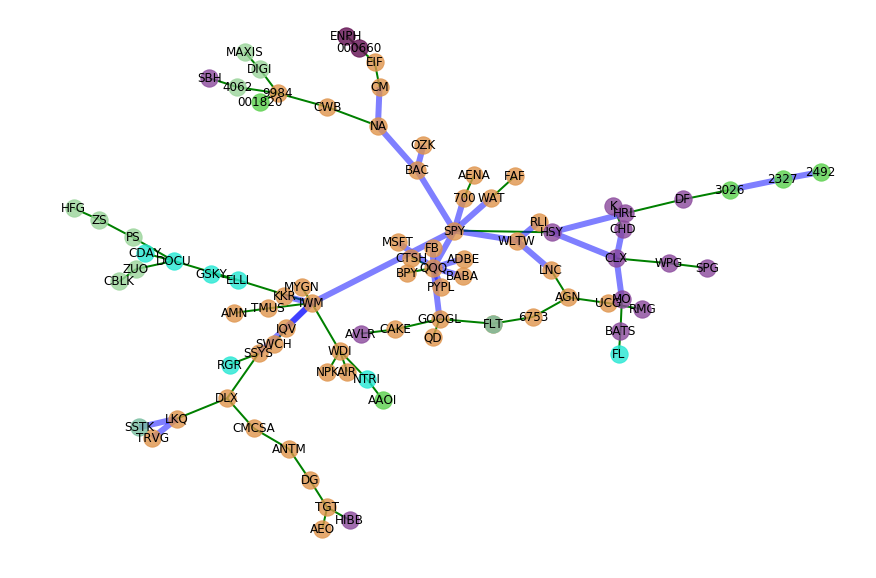

In [8]:
#dataSet: dfNorm
start_date = '2018-1-2'
end_date = '2018-7-2'

k = 7 #Set number of centroids

look_back = 5 

##==================== look back days =======================##

ret, stocks, company = read_file('portfolio.csv', look_back)
# stocks = []
# ticker = input('Please enter the stock ticker (to end type #): ')
# while ( ticker != '#'):
#     stocks += ticker.split(',')
#     ticker = input('Please enter the stock ticker (to end type #): ')
# stocks = set(stocks)
# print(stocks)

# ret = load_data(stocks, look_back)

dfNorm = ret.loc[start_date : end_date].dropna(axis=1, how='all').fillna(0.0)  

# # now every row of "dataMat" is a factor
dataMat = np.mat(dfNorm).T

myC, CA = kMeans(dataMat,k)
stock_list_cl = [i.split()[0] for i in dfNorm.columns.values]

print ("MST with K-means (look_back_period = {a:d} days): ".format(a=look_back))
for i in range(k):
    print("Cluster %i: %s" %((i+1), ', '.join([stock_list_cl[j] for j in range(len(CA[:,0])) if CA[j, 0] == i])))

clusters = [[] for _ in range(k)]
for i in range(len(CA)):
    clusters[int(CA[i, 0])] += [i]
plot_stock_tree(dataMat, clusters, stock_list_cl, k)       
